# India Air Quality - Exploratory Data Analysis

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer # Needed to impute NaN values which exist

%matplotlib inline


In [5]:
aqi = pd.read_csv('data.csv', encoding = "ISO-8859-1", parse_dates=['date'], low_memory=False)
aqi.head()

,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [6]:
sns.set(style="ticks", rc = {'figure.figsize':(20,15)})

# Supressing update warnings

import warnings
warnings.filterwarnings('ignore')

# Dataset

In [7]:
# checking the original dataset
print(aqi.isnull().sum())
print(aqi.shape)
aqi.info()

stn_code                       144077
sampling_date                       3
state                               0
location                            3
agency                         149481
type                             5393
so2                             34646
no2                             16233
rspm                            40222
spm                            237387
location_monitoring_station     27491
pm2_5                          426428
date                                7
dtype: int64
(435742, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   stn_code                     291665 non-null  object        
 1   sampling_date                435739 non-null  object        
 2   state                        435742 non-null  object        
 3   location                     43573

# Checking the dataset

We can see that there are quite a number of NaNs in the dataset. 
To proceed with the EDA, we must handle these NaNs by either removing them or filling them. I will be doing both.



In [8]:
# Cleaning up the data

aqi.drop(['stn_code','agency','sampling_date','location_monitoring_station'], axis=1, inplace=True , errors='ignore') #dropping columns that aren't required
aqi = aqi.dropna(subset=['date']) # dropping rows where no date is available

# cleaning up name changes

aqi.state = aqi.state.replace({'Uttaranchal':'Uttarakhand'})
aqi.state[aqi.location == "Jamshedpur"] = aqi.state[aqi.location == 'Jamshedpur'].replace({"Bihar":"Jharkhand"})

#changing types to uniform format

types = {
    "Residential": "R",
    "Residential and others": "RO",
    "Residential, Rural and other Areas": "RRO",
    "Industrial Area": "I",
    "Industrial Areas": "I",
    "Industrial": "I",
    "Sensitive Area": "S",
    "Sensitive Areas": "S",
    "Sensitive": "S",
    np.nan: "RRO"
}
aqi.type = aqi.type.replace(types)

In [9]:
aqi.head()

,state,location,type,so2,no2,rspm,spm,pm2_5,date
0,Andhra Pradesh,Hyderabad,RRO,4.8,17.4,NaN,NaN,NaN,1990-02-01
1,Andhra Pradesh,Hyderabad,I,3.1,7.0,NaN,NaN,NaN,1990-02-01
2,Andhra Pradesh,Hyderabad,RRO,6.2,28.5,NaN,NaN,NaN,1990-02-01
3,Andhra Pradesh,Hyderabad,RRO,6.3,14.7,NaN,NaN,NaN,1990-03-01
4,Andhra Pradesh,Hyderabad,I,4.7,7.5,NaN,NaN,NaN,1990-03-01


# Filling NaNs

In [10]:
# defining columns of importance, which shall be used reguarly
VALUE_COLS = ['so2', 'no2', 'rspm', 'spm', 'pm2_5']

In [11]:
# invoking SimpleImputer to fill missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
aqi[VALUE_COLS] = imputer.fit_transform(aqi[VALUE_COLS])

In [12]:
# checking to see if the dataset has any null values left over and the format
print(aqi.isnull().sum())
aqi.tail()

state       0
location    0
type        0
so2         0
no2         0
rspm        0
spm         0
pm2_5       0
date        0
dtype: int64


,state,location,type,so2,no2,rspm,spm,pm2_5,date
435734,West Bengal,ULUBERIA,RIRUO,20.0,44.0,148.0,220.78348,40.791467,2015-12-15
435735,West Bengal,ULUBERIA,RIRUO,17.0,44.0,131.0,220.78348,40.791467,2015-12-18
435736,West Bengal,ULUBERIA,RIRUO,18.0,45.0,140.0,220.78348,40.791467,2015-12-21
435737,West Bengal,ULUBERIA,RIRUO,22.0,50.0,143.0,220.78348,40.791467,2015-12-24
435738,West Bengal,ULUBERIA,RIRUO,20.0,46.0,171.0,220.78348,40.791467,2015-12-29


# Plotting pollutant levels as yearly averages for states 

In [13]:
# defining a function that plots SO2, NO2, RSPM and SPM yearly average levels for a given state
# since data is available monthly, it was resampled to a year and averaged to obtain yearly averages
# years for which no data was collected has not been imputed
def plot_for_state(state):
    fig, ax = plt.subplots(2,2, figsize=(20,12))
    fig.suptitle(state, size=20)
    state = aqi[aqi.state == state]
    state = state.reset_index().set_index('date')[VALUE_COLS].resample('Y').mean()
    state.so2.plot(legend=True, ax=ax[0][0], title="so2")
    ax[0][0].set_ylabel("so2 (µg/m3)")
    ax[0][0].set_xlabel("Year")
    
    state.no2.plot(legend=True, ax=ax[0][1], title="no2")
    ax[0][1].set_ylabel("no2 (µg/m3)")
    ax[0][1].set_xlabel("Year")
    
    state.rspm.plot(legend=True, ax=ax[1][0], title="rspm")
    ax[1][0].set_ylabel("RSPM (PM10 µg/m3)")
    ax[1][0].set_xlabel("Year")
    
    state.spm.plot(legend=True, ax=ax[1][1], title="spm")
    ax[1][1].set_ylabel("SPM (PM10 µg/m3)")
    ax[1][1].set_xlabel("Year")

In [3]:
plot_for_state("Nagaland")

NameError: name 'plot_for_state' is not defined



## Plotting highest and lowest ranking states


In [16]:
# defining a function to find and plot the top 10 and bottom 10 states for a given indicator (defaults to SO2)
def top_and_bottom_10_states(indicator="so2"):
    fig, ax = plt.subplots(2,1, figsize=(20, 12))
    
    ind = aqi[[indicator, 'state']].groupby('state', as_index=False).median().sort_values(by=indicator,ascending=False)
    top10 = sns.barplot(x='state', y=indicator, data=ind[:10], ax=ax[0], color='red')
    top10.set_title("Top 10 states by {} (1991-2016)".format(indicator))
    top10.set_ylabel("so2 (µg/m3)")
    top10.set_xlabel("State")
    
    bottom10 = sns.barplot(x='state', y=indicator, data=ind[-10:], ax=ax[1], color='green')
    bottom10.set_title("Bottom 10 states by {} (1991-2016)".format(indicator))
    bottom10.set_ylabel("so2 (µg/m3)")
    bottom10.set_xlabel("State")

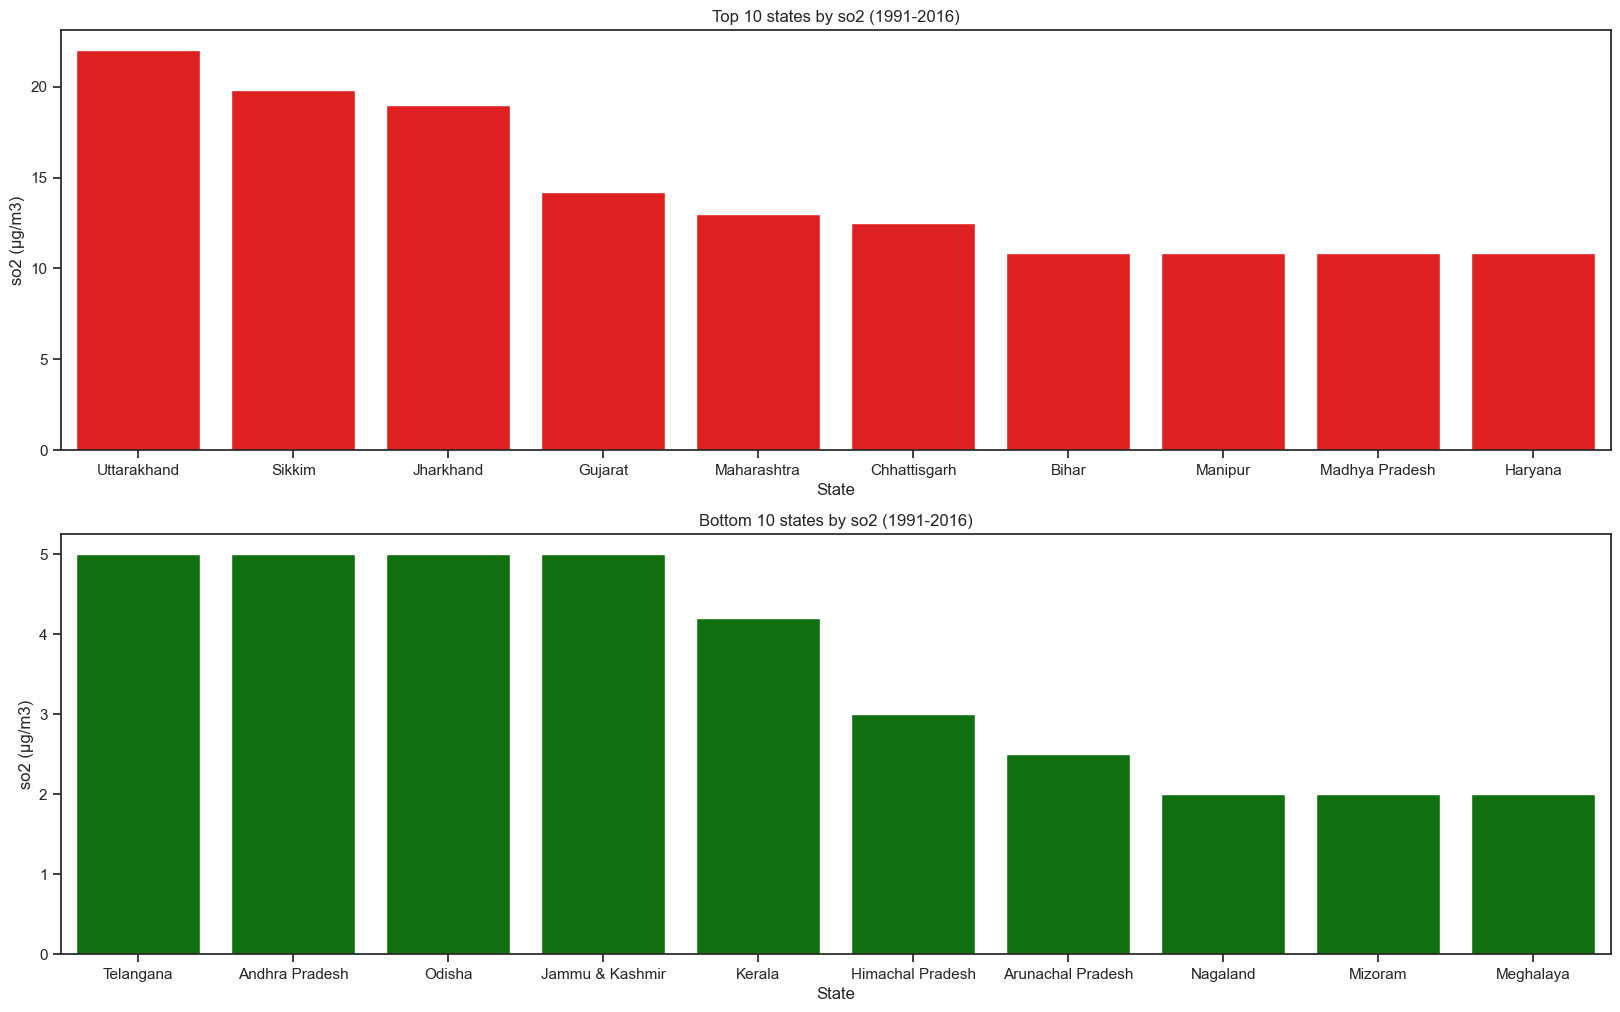

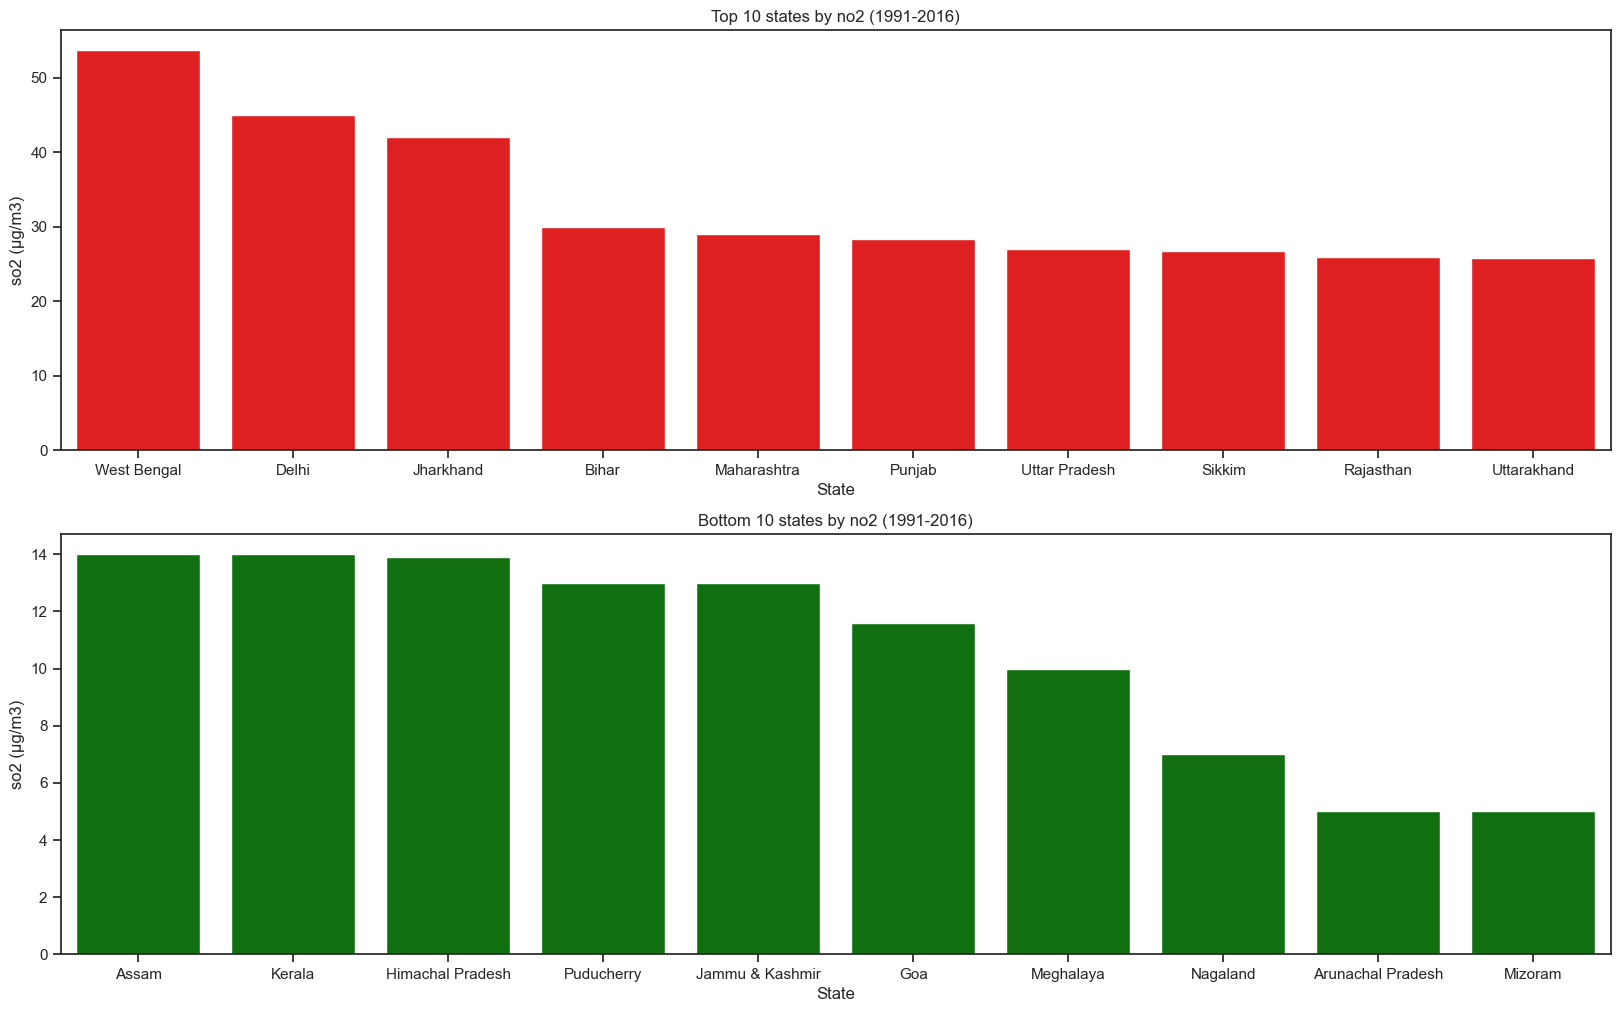

In [17]:
top_and_bottom_10_states("so2")
top_and_bottom_10_states("no2")

# Plotting the highest ever recorded levels

In [19]:
# defining a function to find the highest ever recorded levels for a given indicator (defaults to SO2) by state
# sidenote: mostly outliers
def highest_levels_recorded(indicator="so2"):
    plt.figure(figsize=(20,10))
    ind = aqi[[indicator, 'location', 'state', 'date']].groupby('state', as_index=False).max()
    highest = sns.barplot(x='state', y=indicator, data=ind)
    highest.set_title("Highest ever {} levels recorded by state".format(indicator))
    plt.xticks(rotation=90)

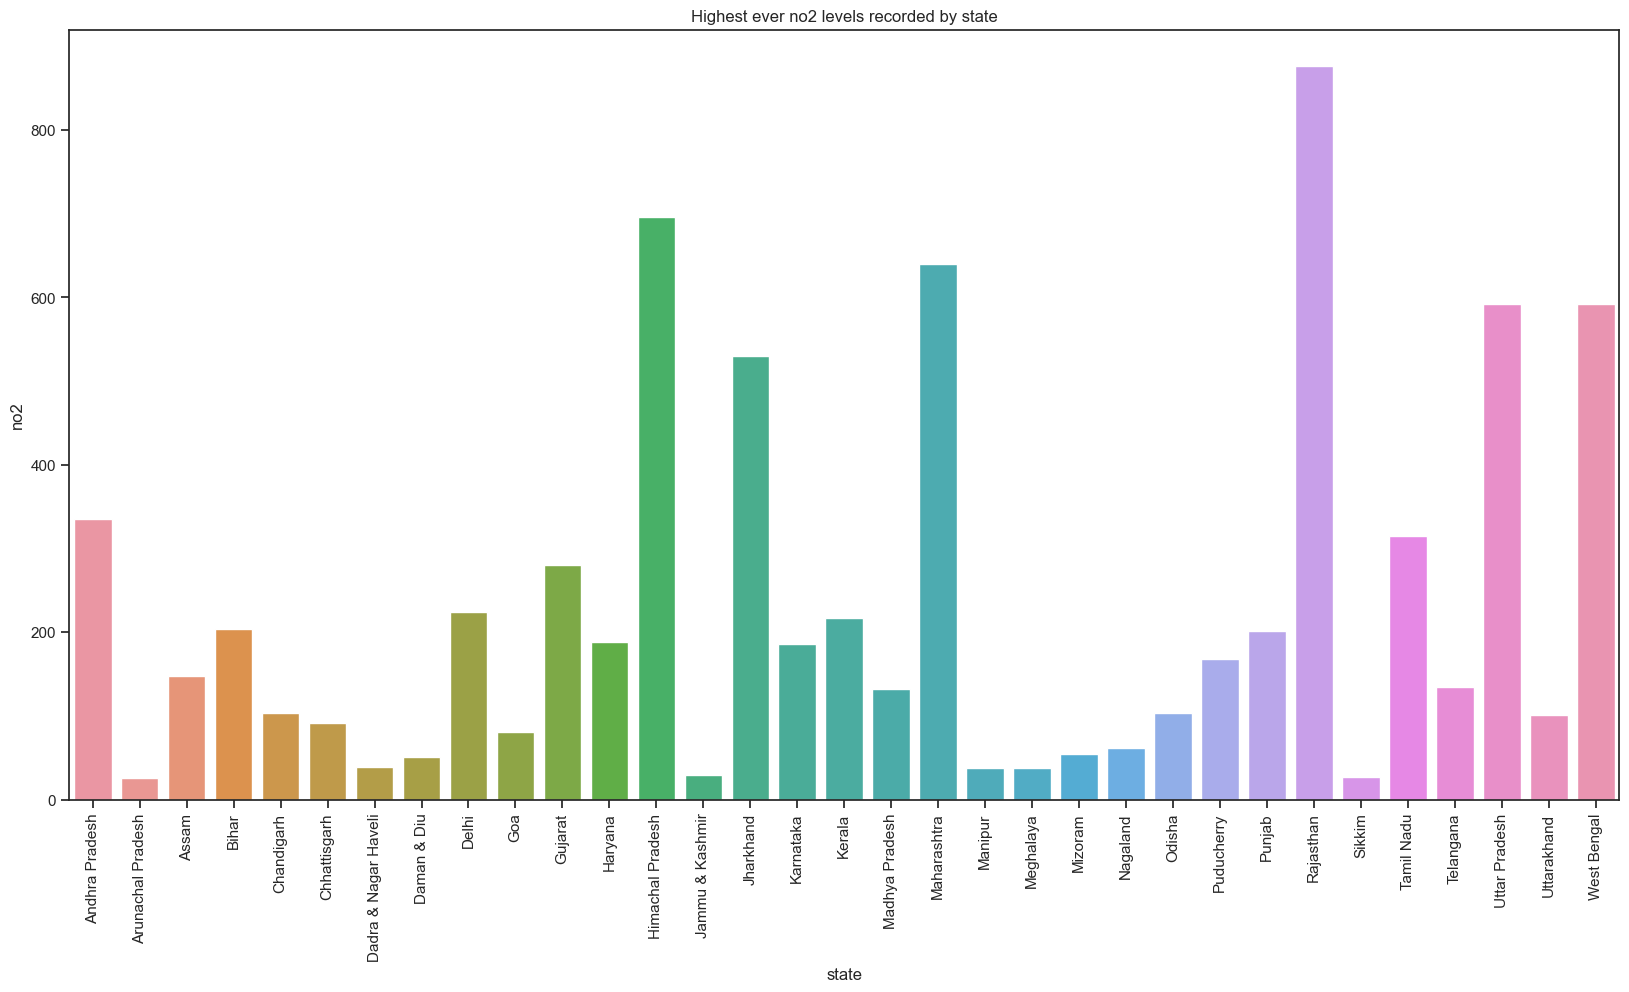

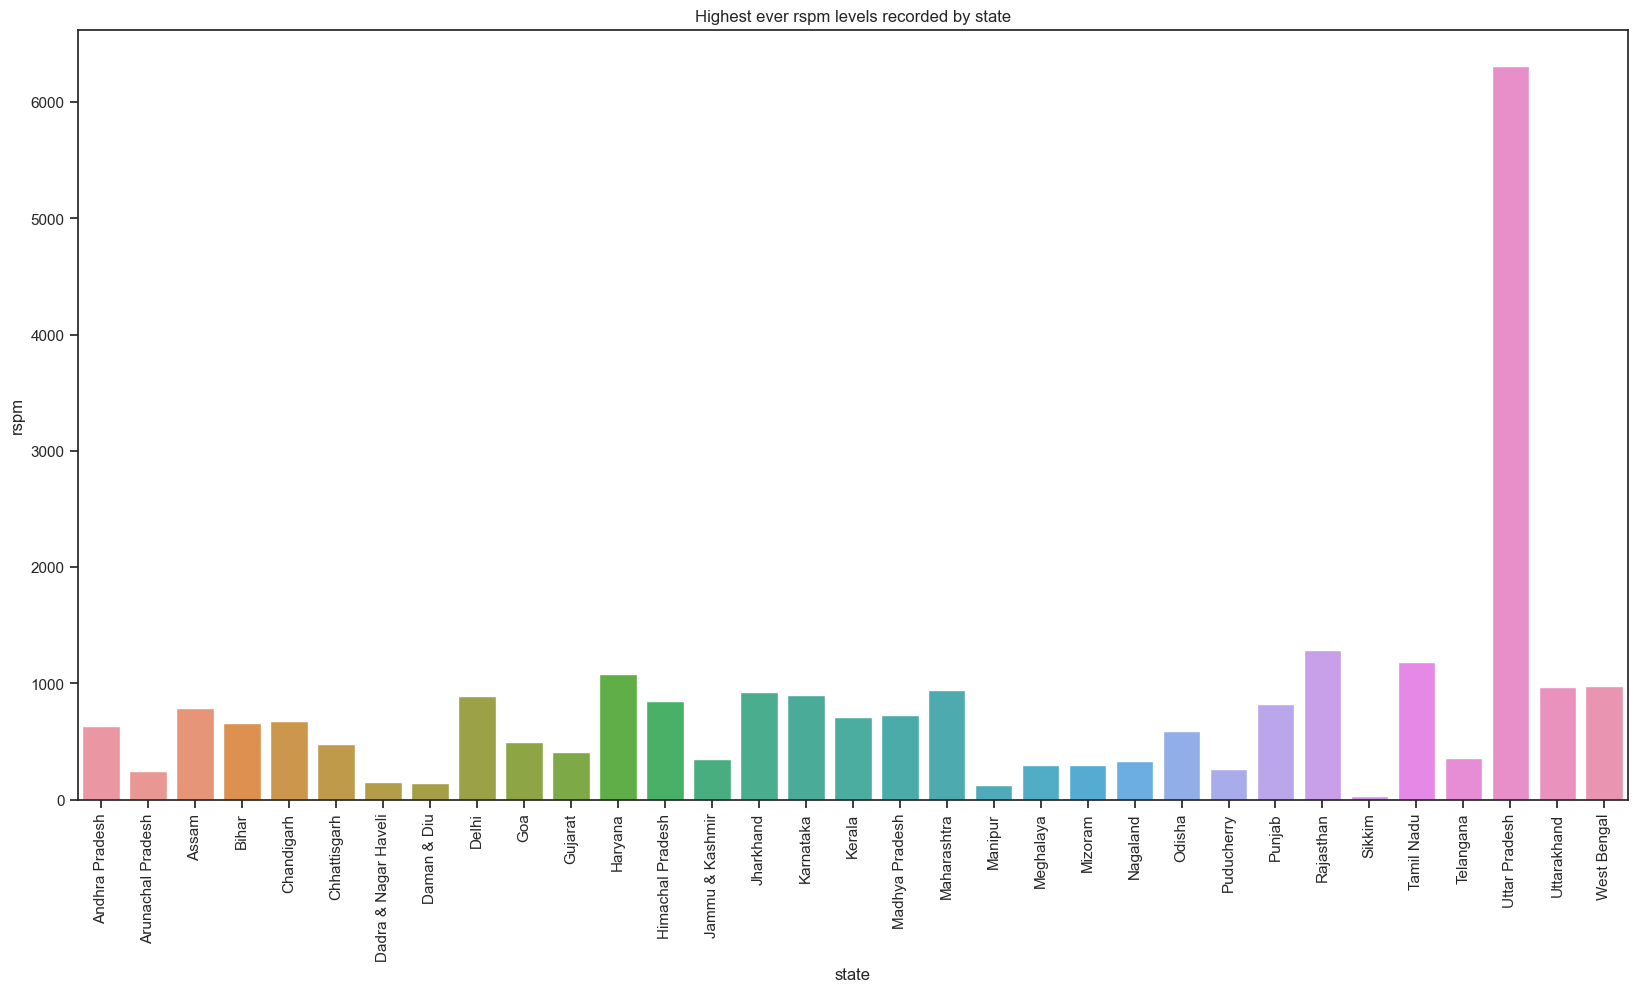

In [20]:
highest_levels_recorded("no2")
highest_levels_recorded("rspm")

Plotting for `NO2`, we can see that `Rajasthan` recorded the highest ever NO2 level.
Plotting for `RSPM`, we can see that `Uttar Pradesh` recorded the highest ever RSPM level.

## Plotting yearly trends

In [21]:
# defining a function to plot the yearly trend values for a given indicator (defaults to SO2) and state (defaults to overall)
def yearly_trend(state="", indicator="so2", ):
    plt.figure(figsize=(20,12))
    aqi['year'] = aqi.date.dt.year
    if state is "":
        year_wise = aqi[[indicator, 'year', 'state']].groupby('year', as_index=False).median()
        trend = sns.pointplot(x='year', y=indicator, data=year_wise)
        trend.set_title('Yearly trend of {}'.format(indicator))
    else:
        year_wise = aqi[[indicator, 'year', 'state']].groupby(['state','year']).median().loc[state].reset_index()
        trend = sns.pointplot(x='year', y=indicator, data=year_wise)
        trend.set_title('Yearly trend of {} for {}'.format(indicator, state))

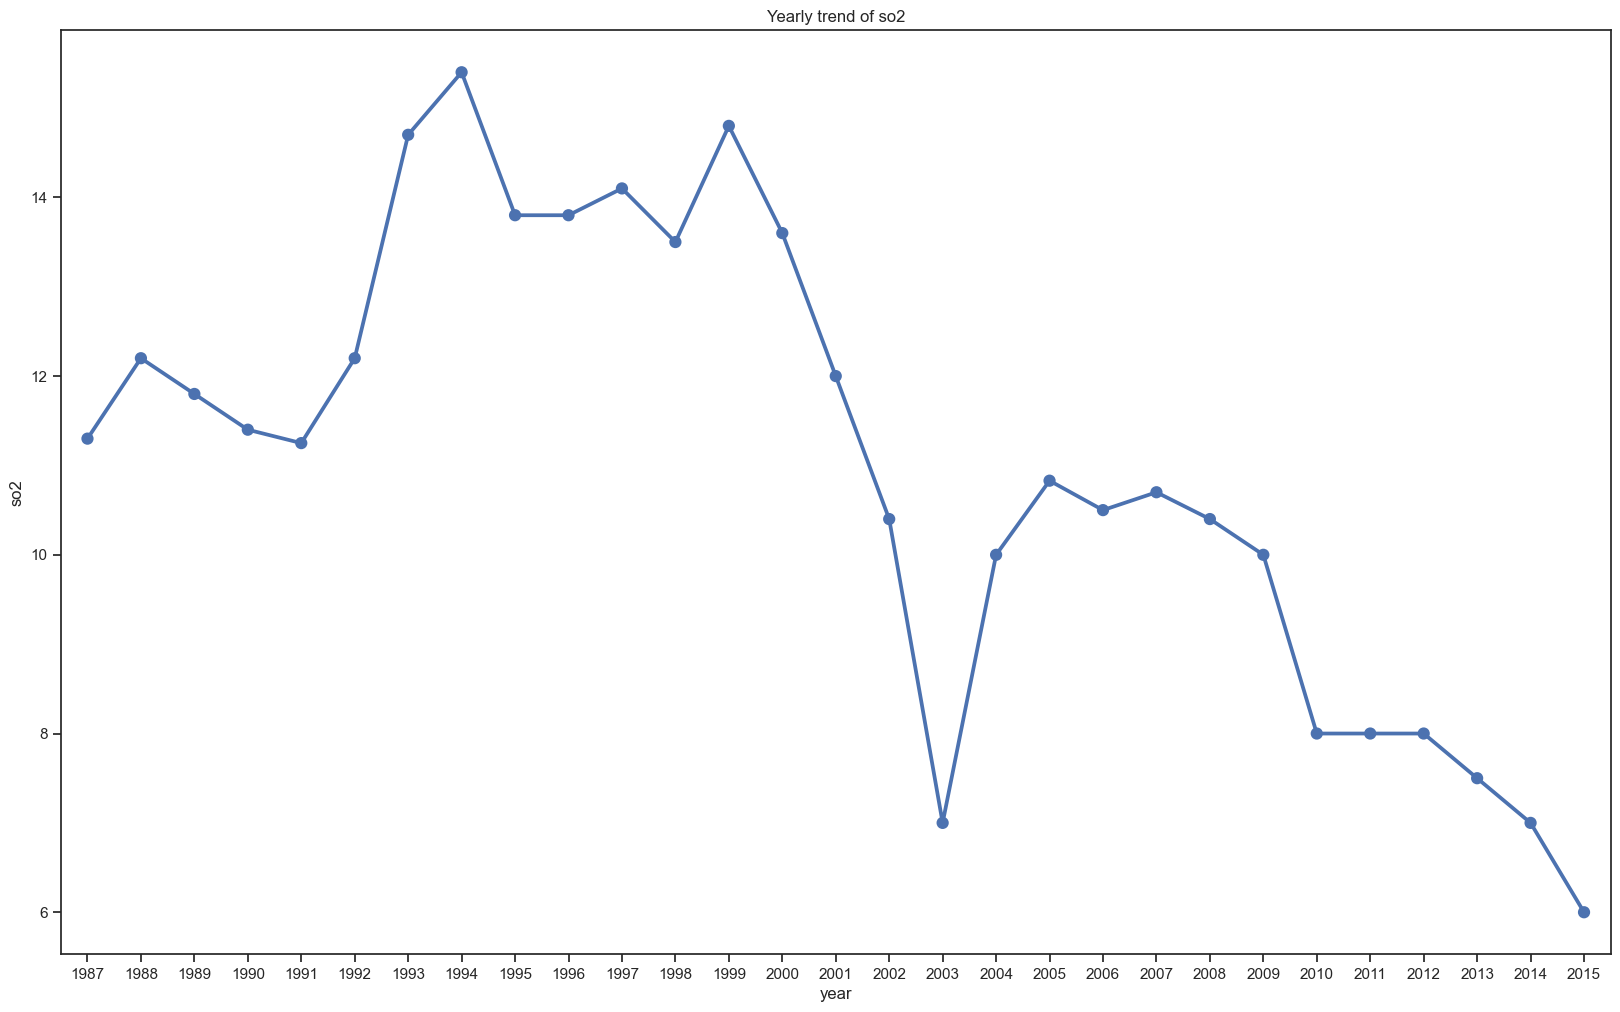

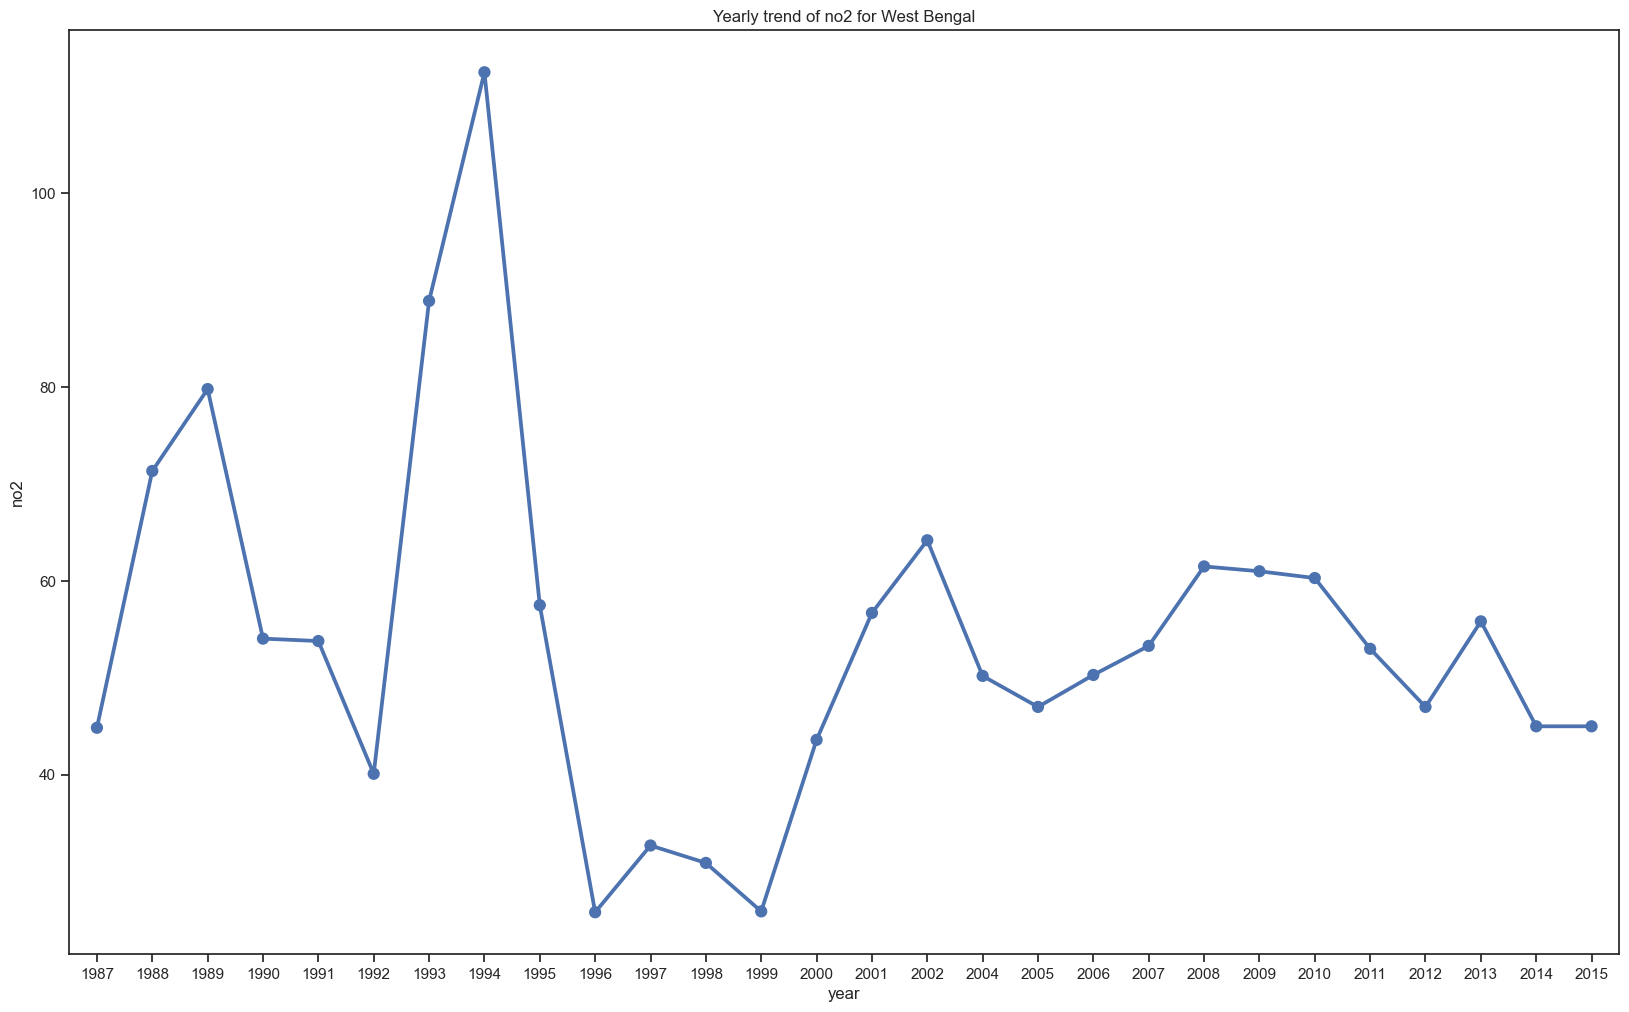

In [22]:
yearly_trend()
yearly_trend("West Bengal", "no2")

Plotting for `SO2` and `NO2`, we see a fairly positively sloped line indicating that the two pollutants move simultaneously. 

## Plotting pollutant average by type

In [15]:
# defining a function to plot pollutant averages by type for a given indicator
def type_avg(indicator=""):
    type_avg = aqi[VALUE_COLS + ['type', 'date']].groupby("type").mean()
    if indicator is not "":
        t = type_avg[indicator].plot(kind='bar')
        plt.xticks(rotation = 0)
        plt.title("Pollutant average by type for {}".format(indicator))
    else:
        t = type_avg.plot(kind='bar')
        plt.xticks(rotation = 0)
        plt.title("Pollutant average by type")

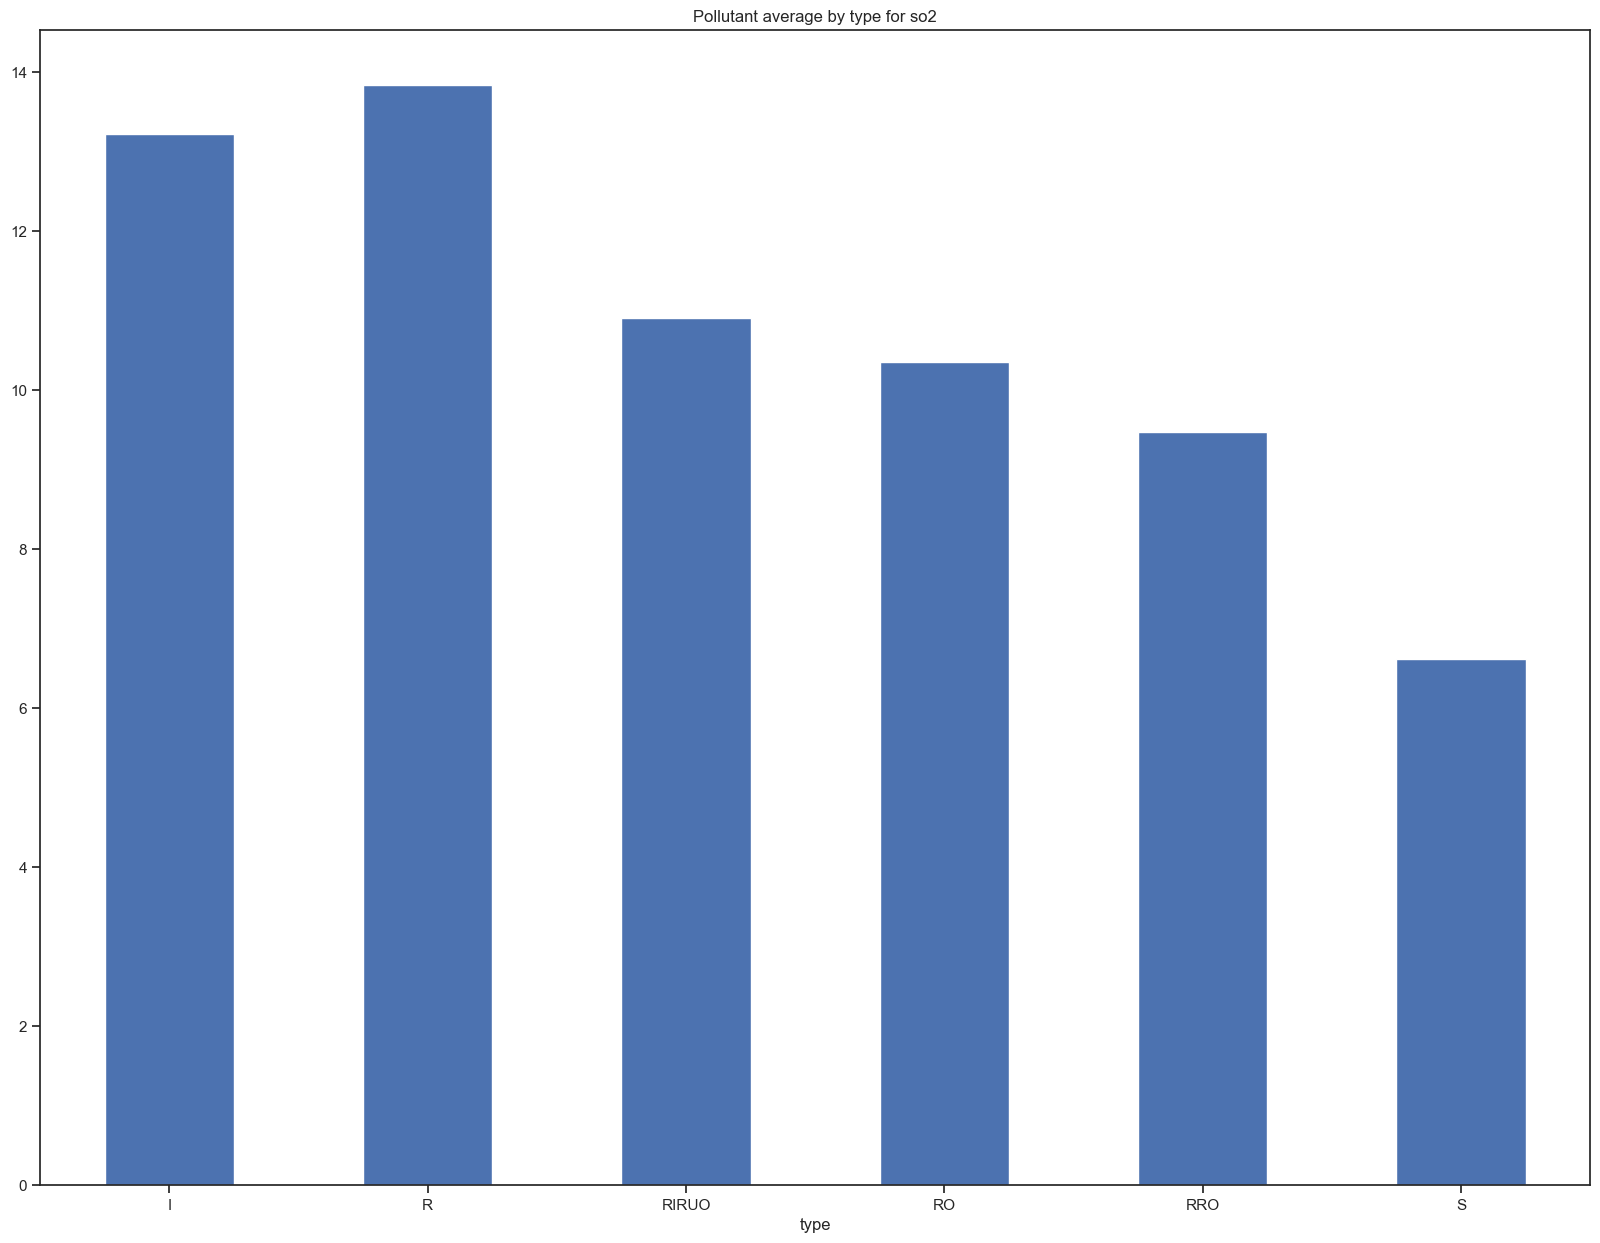

In [16]:
type_avg('so2')

Plotting for `SO2`, we can see that the `Residential` areas generate most SO2, follwed closely by industrial areas.

## Plotting pollutant averages by locations/state

In [29]:
# defining a function to plot pollutant averages for a given indicator (defaults to SO2) by locations in a given state
def location_avgs(state, indicator="so2"):
    locs = aqi[VALUE_COLS + ['state', 'location', 'date']].groupby(['state', 'location']).mean()
    state_avgs = locs.loc[state].reset_index()
    sns.barplot(x='location', y=indicator, data=state_avgs)
    plt.title("Location-wise average for {} in {}".format(indicator, state))
    plt.xticks(rotation = 90)

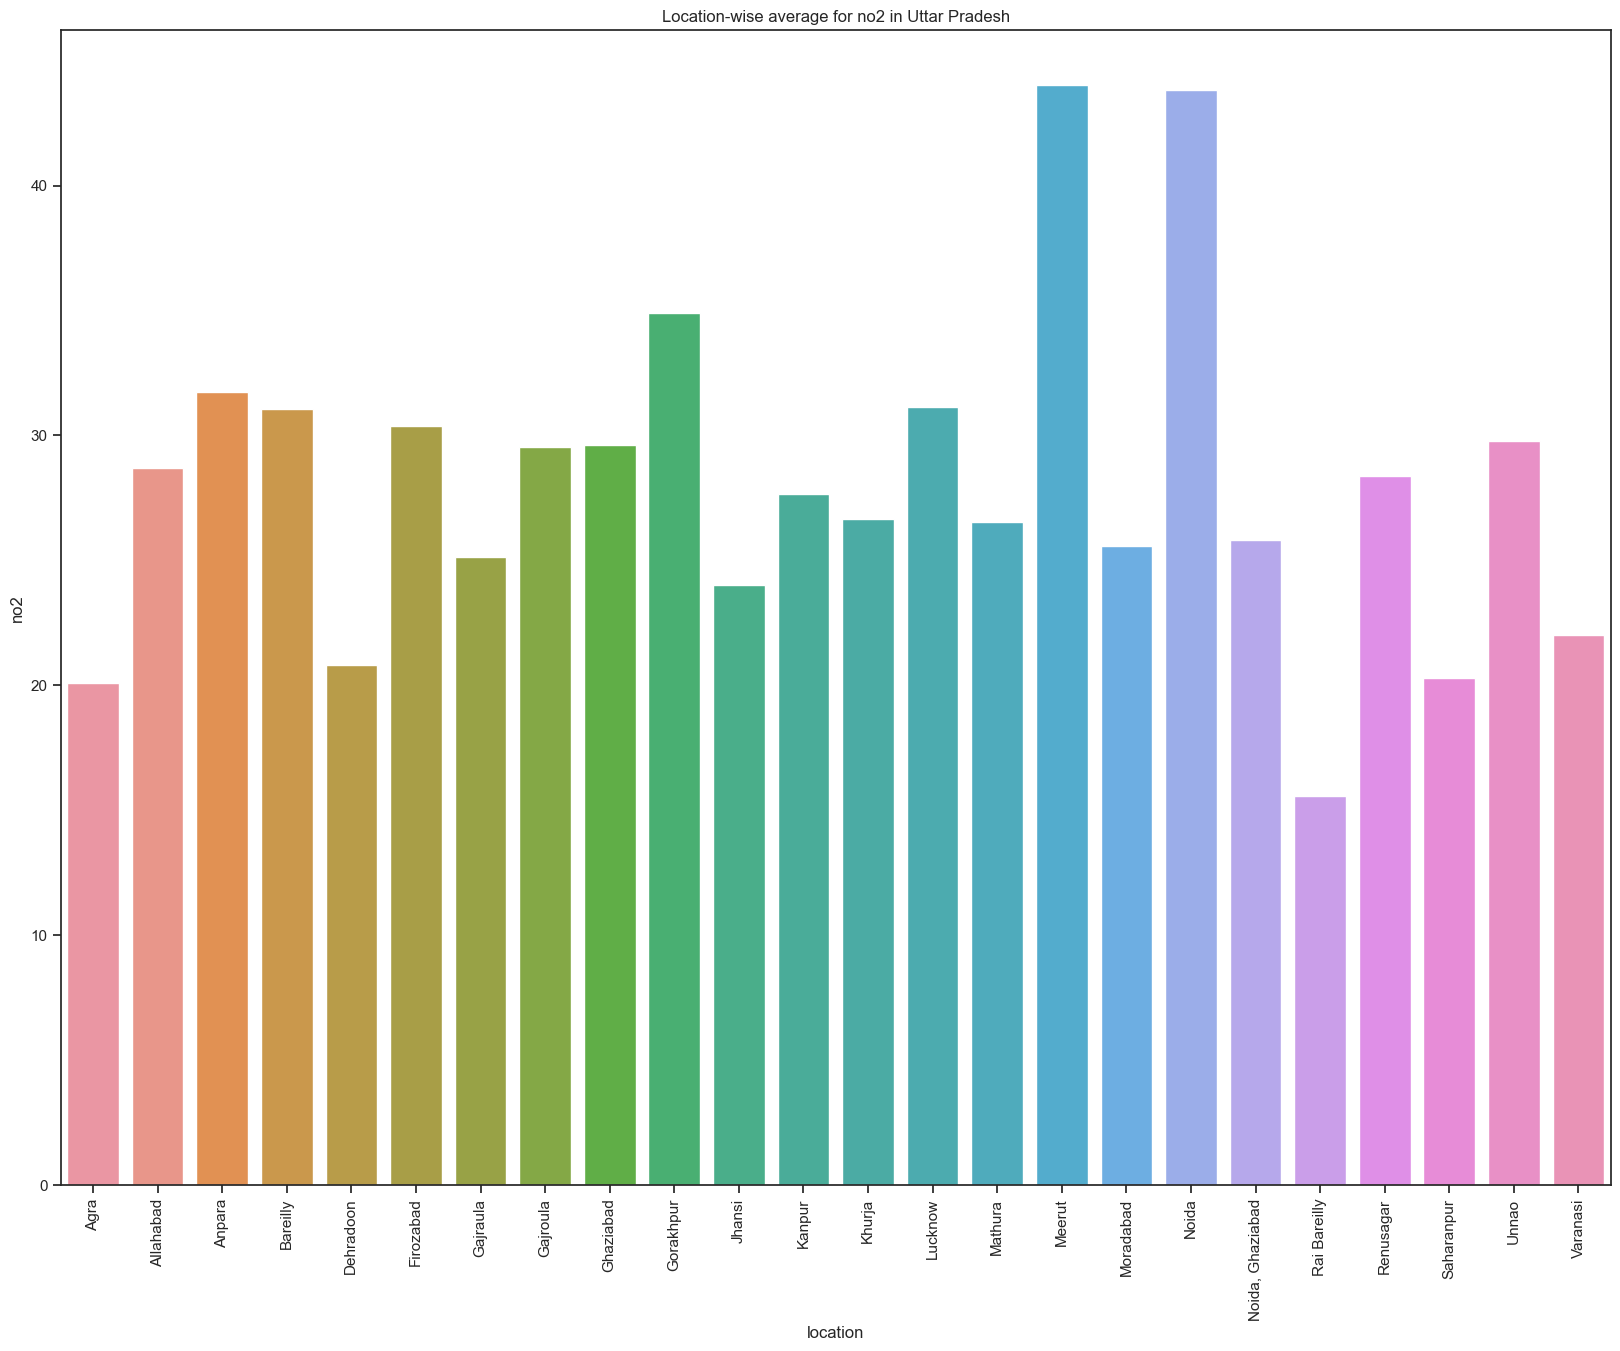

In [30]:
location_avgs("Uttar Pradesh", "no2")

Plottting for `NO2` and `Uttar Pradesh`, we can see that `Meerut` and `Noida` emitted the most NO2 on average.